In [479]:
import numpy as np
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [480]:
n_cluster = 3
z_list = np.array([0.2, 0.5, 0.3])
colors = ["r", "g", "b"]

# random.seed(1)
random.seed(18)

n_sample = 500

mu_list = stats.uniform(loc=-3, scale=6).rvs(size=(3, 2))
# mu_list = np.array([[2, 0], [0, 2], [-3, 1]])
cov_list = stats.invwishart(df=3, scale=np.eye(2)).rvs(3)
# cov_list = np.array([[[1.0, 0.7], [0.7, 1.0]],
#                     [[1.0, -0.8],[-0.8, 1.0]],
#                     [[1.0, 0.6],[0.6, 1.0]]])

# 各サンプルをどの分布から発生させるか
lab = random.choice(n_cluster, n_sample, p = z_list)
class_count = Counter(lab)

data = []
for i in range(n_cluster):
    y = stats.multivariate_normal(mean=mu_list[i], cov=cov_list[i]).rvs(class_count[i])
    data.append(y)

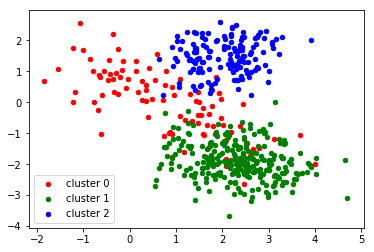

In [481]:
for i, y in enumerate(data):
    plt.scatter(y[:,0], y[:,1], s=20, c=colors[i], label=f'cluster {i}')
plt.legend()

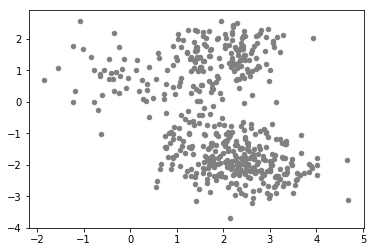

In [482]:
D = np.vstack(data)
plt.scatter(D[:,0], D[:,1], s=20, c="gray")

In [483]:
X = Y = np.linspace(-5, 5)
XX, YY = np.meshgrid(X, Y)

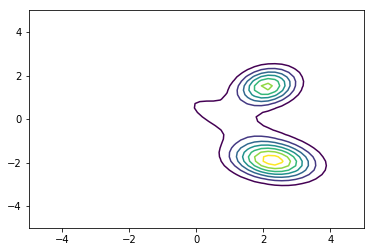

In [484]:
# 混合分布の確率密度関数
pdfs = np.zeros(len(XX.ravel()))
for i in range(n_cluster):
    pdfs += z_list[i] * stats.multivariate_normal(mean=mu_list[i], cov=cov_list[i]).pdf(list(zip(XX.ravel(), YY.ravel())))
    
ZZ = pdfs.reshape(50, 50)

plt.contour(XX, YY, ZZ)
# plt.xlim(-1, 4)
# plt.ylim(-4, 3)

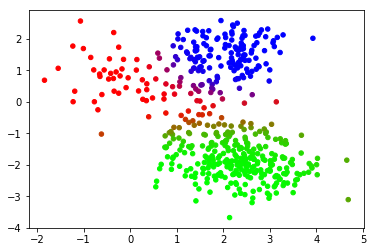

In [485]:
# 負担率
L = np.zeros((n_sample, n_cluster))
for i in range(n_cluster):
    L[:,i] = z_list[i] * stats.multivariate_normal(mean=mu_list[i], cov=cov_list[i]).pdf(D)
    
gamma = L / L.sum(axis=1)[:, np.newaxis]

# RGBで色指定
plt.scatter(D[:,0], D[:,1], s=20, c=gamma)

## EMアルゴリズム
* ステップ１：平均、分散、混合係数のパラメータをランダムに初期化
* ステップ2（Eステップ）：負担率resopnsibility（事後確率）の算出
* ステップ3(Mステップ）：尤度を最大化する平均、分散、混合係数を再計算

In [486]:
def calc_L(data, mu, cov, pi):
    L = np.zeros((len(data), len(pi)))
    for i in range(len(pi)):
        L[:,i] = pi[i] * stats.multivariate_normal(mean=mu[i], cov=cov[i]).pdf(data)
    return L

decrease of log likelihood: 4019.4299
decrease of log likelihood: 17.1372
decrease of log likelihood: 5.2259
decrease of log likelihood: 1.8730
decrease of log likelihood: 1.0570
decrease of log likelihood: 0.8002
decrease of log likelihood: 0.6561
decrease of log likelihood: 0.5352
decrease of log likelihood: 0.4267
decrease of log likelihood: 0.3341
decrease of log likelihood: 0.2597
decrease of log likelihood: 0.2027
decrease of log likelihood: 0.1604
decrease of log likelihood: 0.1299
decrease of log likelihood: 0.1084
decrease of log likelihood: 0.0936
decrease of log likelihood: 0.0835
decrease of log likelihood: 0.0766
decrease of log likelihood: 0.0720
decrease of log likelihood: 0.0688
decrease of log likelihood: 0.0665
decrease of log likelihood: 0.0648
decrease of log likelihood: 0.0634
decrease of log likelihood: 0.0622
decrease of log likelihood: 0.0609
decrease of log likelihood: 0.0596
decrease of log likelihood: 0.0582
decrease of log likelihood: 0.0566
decrease of log 

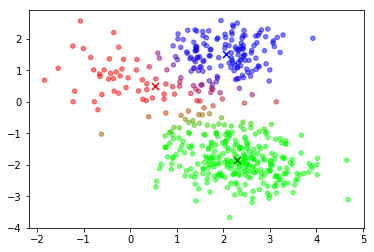

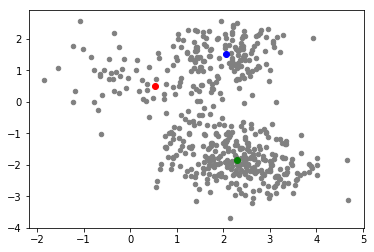

In [488]:
threshold = 1e-4

## mu, Sigma, piの初期化
(xmin, ymin), (xmax, ymax) = D.min(axis=0), D.max(axis=0)

random.seed(0)
mu_x = random.uniform(xmin, xmax, n_cluster)
mu_y = random.uniform(ymin, ymax, n_cluster)
mu = np.c_[mu_x, mu_y]

cov = np.tile(0.1 * np.eye(2), (n_cluster, 1, 1))
pi = random.dirichlet(1000 * np.ones(n_cluster))

## E Step 
L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()


for step in range(200):
    loglike_prev = loglike
    
    ## E Step 
    # responsibility
    gamma = L / L.sum(axis=1, keepdims=True)

    ## M Step
    # 各クラスターの実質的なデータ数
    n_k = gamma.sum(axis=0)

    # 負担率による重み付き和
    mu = np.zeros((n_cluster, 2))
    for k in range(n_cluster):
        mu[k] = (gamma[:,k, np.newaxis] * D).sum(axis=0) / n_k[k]

    # 共分散行列
    cov = np.zeros((n_cluster, 2, 2))
    for k in range(n_cluster):
        diff = D - mu[k]
        sigma = np.dot(diff.T, gamma[:, k, np.newaxis] * diff) / n_k[k]
        cov[k] = sigma

    # 混合係数
    pi = n_k / n_sample
    
    ## calculate log likelihood
    L = calc_L(D, mu, cov, pi)
    loglike = np.log(L.sum(axis=1)).sum()

    loglike_diff = loglike - loglike_prev
    
    print("decrease of log likelihood: {0:.4f}".format(loglike_diff))
    
    if loglike_diff < threshold:
        print(f"log likelihood converged after {step} iteration")
        break
    
# 負担率を色で表現
plt.figure()
plt.scatter(D[:,0], D[:,1], s=20, c=gamma, alpha=0.5)
for i in range(n_cluster):
    plt.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])


plt.figure()
plt.scatter(D[:,0], D[:,1], s=20, c="gray")
for i in range(n_cluster):
    plt.scatter(mu[i, 0], mu[i, 1], c=colors[i])

In [489]:
threshold = 1e-4

## mu, Sigma, piの初期化
(xmin, ymin), (xmax, ymax) = D.min(axis=0), D.max(axis=0)

random.seed(0)
mu_x = random.uniform(xmin, xmax, n_cluster)
mu_y = random.uniform(ymin, ymax, n_cluster)
mu = np.c_[mu_x, mu_y]

cov = np.tile(0.1 * np.eye(2), (n_cluster, 1, 1))
pi = random.dirichlet(1000 * np.ones(n_cluster))

## E Step 
L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()


# for step in range(200):
loglike_prev = loglike

## E Step 
# responsibility
gamma = L / L.sum(axis=1, keepdims=True)

In [509]:
from matplotlib.patches import Ellipse
# draw 95% confidence interval of multivariate normal distribution
def draw_ellipse(mu, cov, ax, **kwargs):
    var, U = np.linalg.eig(cov)
    angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))
#     angle = 180. / np.pi * np.arctan(U[0, 0]/ U[1, 0])

    e = Ellipse(mu, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), 
                angle=angle, facecolor='none', **kwargs)

    ax.add_artist(e)
#     ax.set_xlim(-4, 4)
#     ax.set_ylim(-4, 4)
    

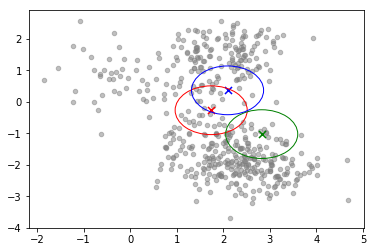

In [510]:
# 95% confidence interval
fig, ax = plt.subplots()
ax.scatter(D[:,0], D[:,1], s=20, c="gray", alpha=0.5)
for i in range(n_cluster):
    ax.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])
    draw_ellipse(mu[i], cov[i], ax, edgecolor=colors[i])

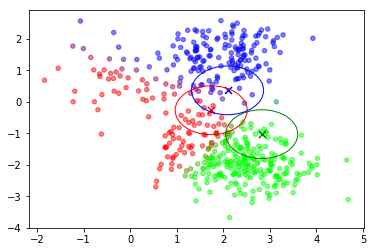

In [511]:
# 負担率を色で表現(E step)
fig, ax = plt.subplots()
ax.scatter(D[:,0], D[:,1], s=20, c=gamma, alpha=0.5)
for i in range(n_cluster):
    ax.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])
    draw_ellipse(mu[i], cov[i], ax, edgecolor=colors[i])

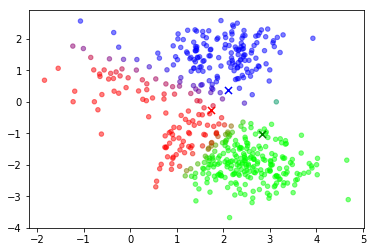

In [490]:
# 負担率を色で表現
plt.figure()
plt.scatter(D[:,0], D[:,1], s=20, c=gamma, alpha=0.5)
for i in range(n_cluster):
    plt.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])

In [338]:
## E Step
# 負担率
L = np.zeros((n_sample, n_cluster))
for i in range(n_cluster):
    L[:,i] = pi[i] * stats.multivariate_normal(mean=mu_init[i], cov=cov_init[i]).pdf(D)
    
gamma = L / L.sum(axis=1)[:, np.newaxis]

In [283]:
## Mステップ
# 負担率による重み付き和
mu_new = np.array([(gamma[:,i][:, np.newaxis] * D).sum(axis=0) / n_k[i] for i in range(n_cluster)])

# 共分散行列
cov_new = np.zeros((n_cluster, 2, 2))
for k in range(n_cluster):
    diff = D - mu_new[0]
    sigma = np.dot(diff.T, gamma[:,k][:, np.newaxis] * diff) / n_k[k]
    cov_new[k] = sigma
    
# 混合係数
pi_new = n_k / n_sample

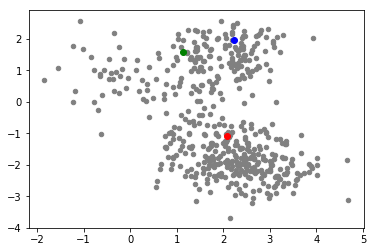

In [284]:
plt.scatter(D[:,0], D[:,1], s=20, c="gray")
for i in range(n_cluster):
    plt.scatter(mu_new[i, 0], mu_new[i, 1], c=colors[i])

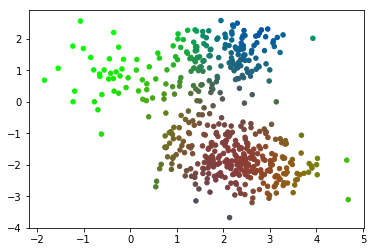

In [285]:
# 負担率
L = np.zeros((n_sample, n_cluster))
for i in range(n_cluster):
    L[:,i] = z_list[i] * stats.multivariate_normal(mean=mu_new[i], cov=cov_new[i]).pdf(D)
    
gamma = L / L.sum(axis=1)[:, np.newaxis]

# RGBで色指定
plt.scatter(D[:,0], D[:,1], s=20, c=gamma)

In [289]:
cov

array([[ 0.31833585,  0.05548478],
       [ 0.05548478,  0.29721809]])